## LIBRISPEECH DATA

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  
from analysis import extract_pos_tag_scores
from preprocessing import normalize_text, load_file
from analysis import calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter

## POS - BUCKET ANALYSE 

In [2]:
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/librispeech/comparemt_output_libri_pos/index.html"

print("POS LABEL TAGGING SCORES – LIBRISPEECH")
df_libri_pos = extract_pos_tag_scores(html_path)
display(df_libri_pos)

POS LABEL TAGGING SCORES – LIBRISPEECH


,Label,kNN-MT (sys1),Vanilla (sys2),Difference (sys1 - sys2)
0,ADJ,0.9561,0.9492,0.0069
1,NOUN,0.9296,0.9203,0.0093
2,PROPN,0.7870,0.7653,0.0217
3,VERB,0.9628,0.9618,0.0010
4,ADV,0.9762,0.9765,-0.0003
5,NUM,0.8806,0.8049,0.0757
6,DET,0.9763,0.9752,0.0011
7,PRON,0.9835,0.9826,0.0009
8,ADP,0.9817,0.9822,-0.0005
9,CCONJ,0.9870,0.9866,0.0004


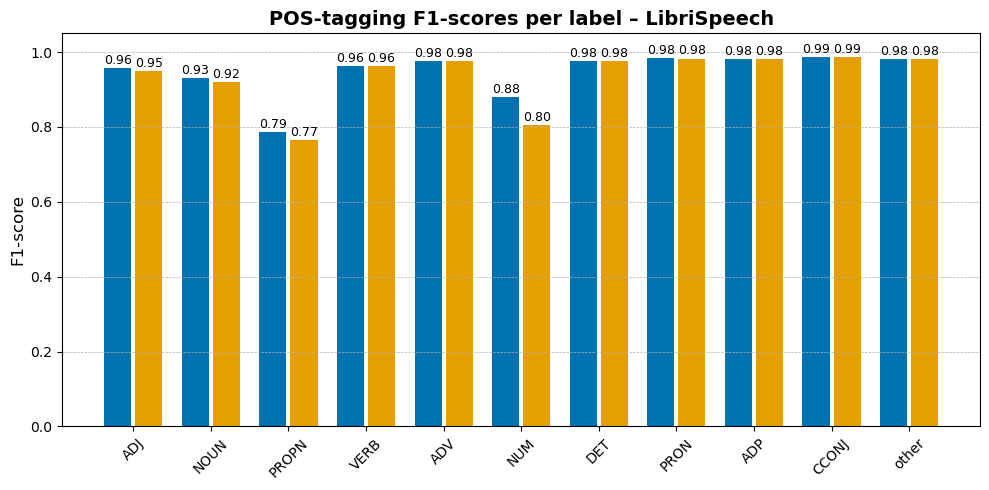

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Kleurenblindvriendelijke kleuren
colors = ["#0072B2", "#E69F00"]

labels = df_libri_pos["Label"]
x = range(len(labels))
width = 0.35
gap = 0.05

# Plot beide systemen met lichte offset
bars1 = ax.bar([i - gap/2 for i in x], df_libri_pos["kNN-MT (sys1)"], width, label="kNN-MT", color=colors[0])
bars2 = ax.bar([i + width + gap/2 for i in x], df_libri_pos["Vanilla (sys2)"], width, label="Vanilla", color=colors[1])

# Annotaties boven de balken
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Aslabels en ticks
ax.set_ylabel("F1-score", fontsize=12)
ax.set_title("POS-tagging F1-scores per label – LibriSpeech", fontsize=14, fontweight='bold')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45, fontsize=10)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis="y", linestyle='--', linewidth=0.5)

# Legenda buiten de plot
plt.tight_layout()
plt.savefig("pos_f1_librispeech.png", dpi=300, bbox_inches="tight")
plt.show()

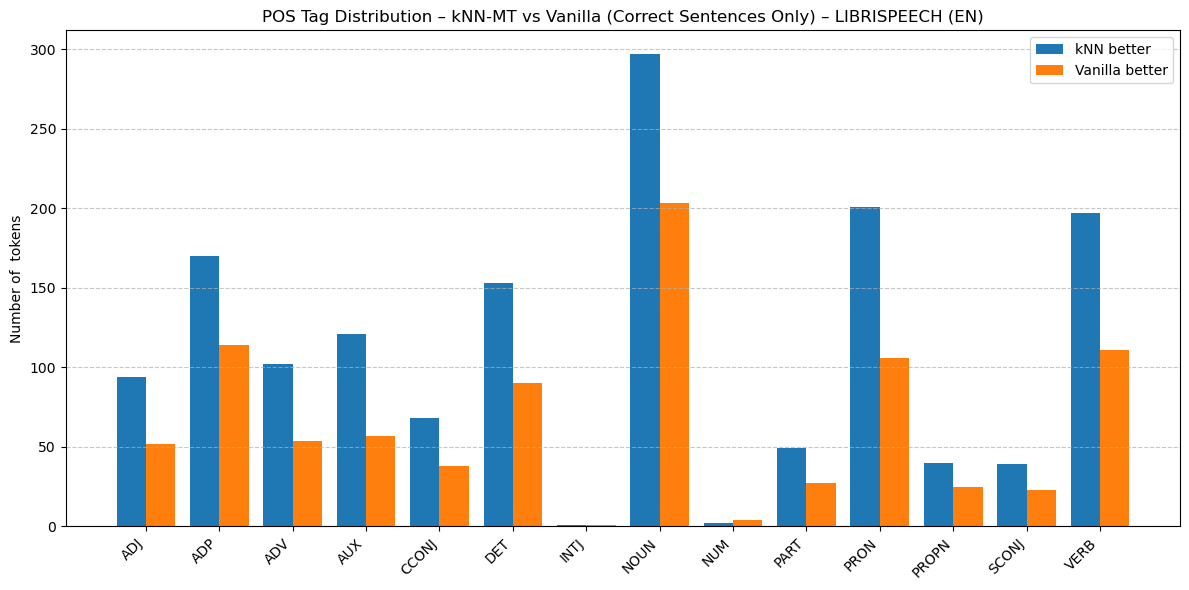

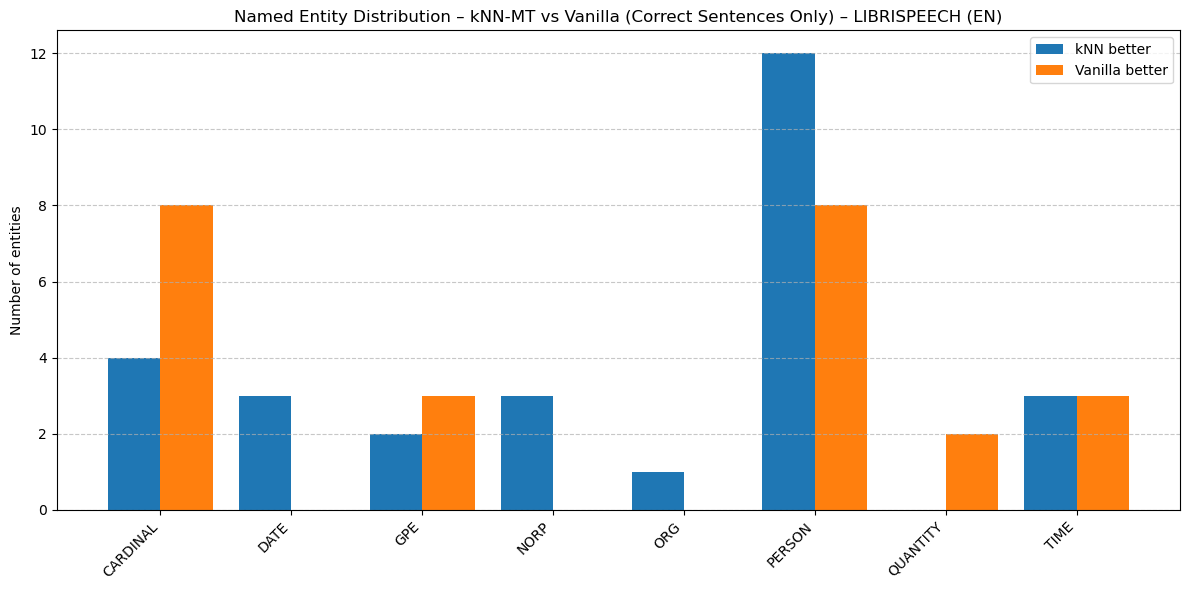

In [4]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/librispeech"
lang = "en"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_clean_normalized_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_clean_normalized_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_clean_normalized_texts.pkl"))


ref = [normalize_text(line) for line in ref]
knn  = [normalize_text(line) for line in knn]
van = [normalize_text(line) for line in van]

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – LIBRISPEECH ({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – LIBRISPEECH ({lang.upper()})",
    ylabel="Number of entities"
)

## WER ANALYSE

In [5]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])

Mean WER (kNN): 0.018481151111697815
Mean WER (van): 0.019009184000603467


In [6]:
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.2)
gain_indices = [entry[0] for entry in gain_outliers]

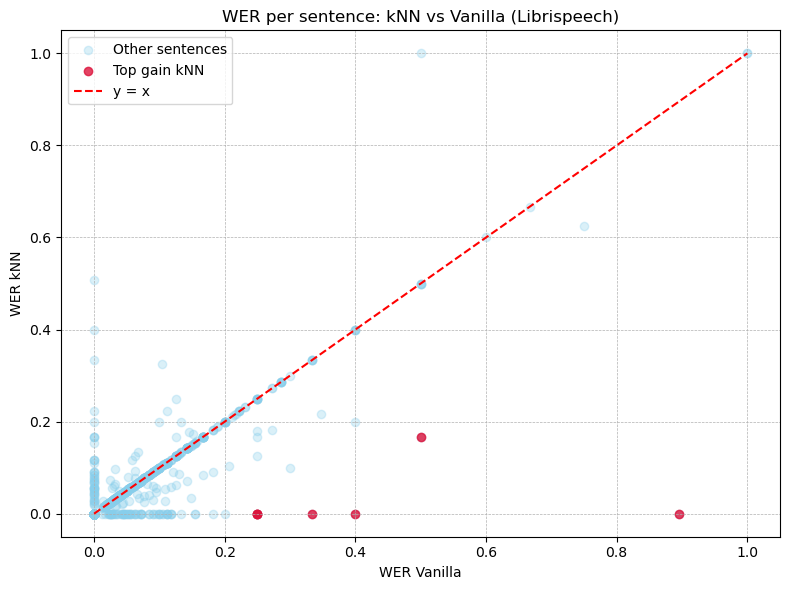

In [7]:
plot_knn_gain_scatter(wer_knn, wer_van,
    gain_indices,
    domain_label="Librispeech"
)

In [8]:
df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)
display(df_gain)  


,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,1137,paul answers the man who is named jesus christ...,paul answers,paul answers the man who is named jesus christ...,0.894737,0.000000,0.894737
1,2569,to morrow is the examination,tomorrow is the examination,to morrow is the examination,0.400000,0.000000,0.400000
2,2118,gram roughly 128th of an ounce,graham roughly one 28th of an ounce,graham roughly 128th of an ounce,0.500000,0.166667,0.333333
3,2602,hans stirs not,han stirs not,hans stirs not,0.333333,0.000000,0.333333
4,2172,those fellows are all very loyal even mainhall,those fellows are all very loyal even main hall,those fellows are all very loyal even mainhall,0.250000,0.000000,0.250000
5,2512,you know captain lake,you know captain leak,you know captain lake,0.250000,0.000000,0.250000
6,2530,the former boolooroo groaned,the former boolaroo groaned,the former boolooroo groaned,0.250000,0.000000,0.250000


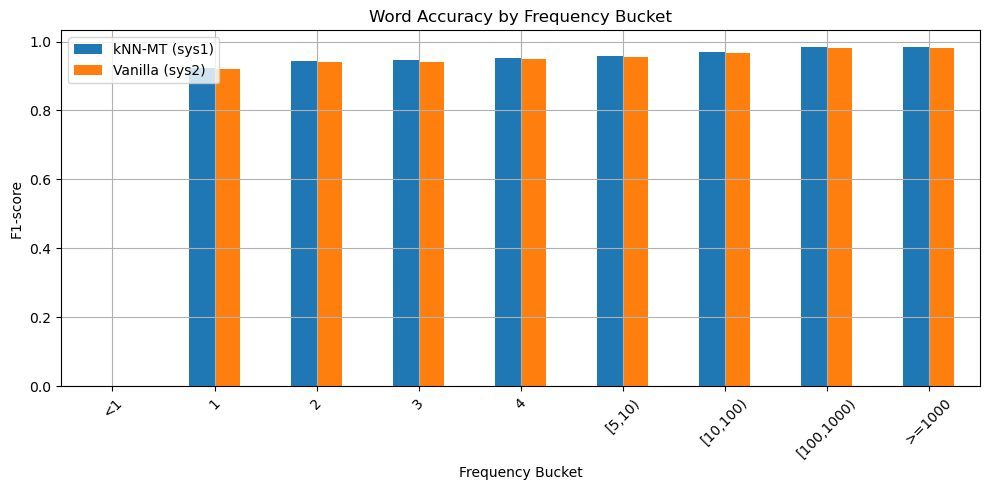

,Frequency Bucket,kNN-MT (sys1),Vanilla (sys2),Difference (sys1 - sys2)
0,<1,0.0000,0.0000,0.0000
1,1,0.9245,0.9205,0.0040
2,2,0.9429,0.9416,0.0013
3,3,0.9455,0.9406,0.0049
4,4,0.9522,0.9489,0.0033
5,"[5,10)",0.9591,0.9547,0.0044
6,"[10,100)",0.9701,0.9653,0.0048
7,"[100,1000)",0.9833,0.9826,0.0007
8,>=1000,0.9827,0.9826,0.0001


In [9]:
from analysis import extract_freq_bucket_scores
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/librispeech/comparemt_output_freq/index.html"

df_commonvoice_pos_TEST = extract_freq_bucket_scores(html_path)
display(df_commonvoice_pos_TEST)